In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

In [3]:
model_df = pd.read_csv('./csvfiles/model_df.csv')

In [4]:
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    
    return train, test

train, test = tts(model_df)

In [5]:
train.shape

(35, 13)

In [6]:
train

array([[   3130.,   19380., -186036.,   36056.,  -33320.,  -76854.,
         -89161.,   60325.,   32355.,   80968.,   64892.,  157965.,
           4513.],
       [ 175184.,    3130.,   19380., -186036.,   36056.,  -33320.,
         -76854.,  -89161.,   60325.,   32355.,   80968.,   64892.,
         157965.],
       [  84613.,  175184.,    3130.,   19380., -186036.,   36056.,
         -33320.,  -76854.,  -89161.,   60325.,   32355.,   80968.,
          64892.],
       [  93963.,   84613.,  175184.,    3130.,   19380., -186036.,
          36056.,  -33320.,  -76854.,  -89161.,   60325.,   32355.,
          80968.],
       [  23965.,   93963.,   84613.,  175184.,    3130.,   19380.,
        -186036.,   36056.,  -33320.,  -76854.,  -89161.,   60325.,
          32355.],
       [  82168.,   23965.,   93963.,   84613.,  175184.,    3130.,
          19380., -186036.,   36056.,  -33320.,  -76854.,  -89161.,
          60325.],
       [-103414.,   82168.,   23965.,   93963.,   84613.,  175184.,
  

In [7]:
test.shape

(12, 13)

In [8]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [9]:
y_train.shape

(35,)

In [10]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [11]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('./csvfiles/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [12]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [13]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [14]:
def plot_results(results, original_df, model_name,date_format):

    fig, ax = plt.subplots(figsize=(15,5))
    if(date_format == 'Daily'):
        date_form = DateFormatter("%d/%m/%Y")
    elif(date_format == 'Monthly'):
        date_form = DateFormatter("%m/%Y")
    elif(date_format == 'Yearly'):
        date_form = DateFormatter("%Y")
    ax.xaxis.set_major_formatter(date_form)
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Actual', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    submission = pd.DataFrame({"Actual_Date":original_df.date,"Actual": original_df['sales'],"Predicted_Date":results.date ,"Predicted": results.pred_value})
    submission.to_csv("salesPred.csv", index=False)
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig(f'./csvfiles/{model_name}_forecast.png')

In [15]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
    date_format = "Daily"
    get_scores(unscaled_df, original_df, model_name)
    plot_results(unscaled_df, original_df, model_name,date_format)
    return mod

RMSE: 16221.040790693221
MAE: 12433.0
R2 Score: 0.9907155879704752


c:\users\manya\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\manya\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


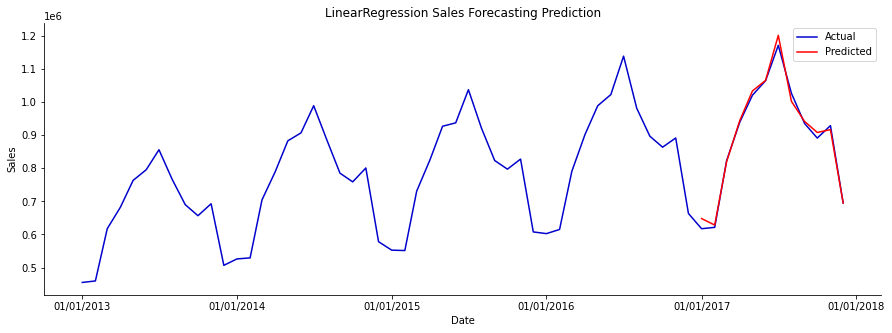

In [16]:
model = run_model(train, test, LinearRegression(), 'LinearRegression')

In [17]:
with open('salespred.pkl','wb') as f:
    pickle.dump(model,f)

In [18]:
print(model)

LinearRegression()


RMSE: 20348.5554524148
MAE: 17197.166666666668
R2 Score: 0.9853895315487026


c:\users\manya\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\manya\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


RandomForestRegressor(max_depth=20)

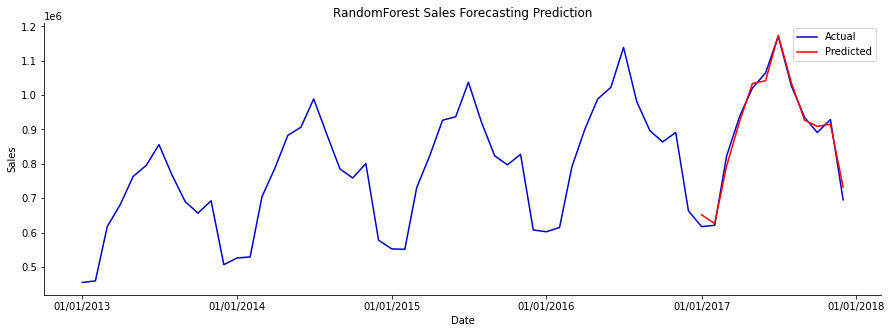

In [22]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 'RandomForest')

In [23]:
with open('salespred.pkl','wb') as f:
    pickle.dump(model,f)

In [24]:
print(model)

LinearRegression()
